# Paper implementation : "Changepoint prediction in the presence of outliers"

This notebook implements the algorithm of the article [Changepoint prediction in the presence of outliers](https://arxiv.org/pdf/1609.07363.pdf) (Fernhead, Rigaill, 2019).

## When the signal has many outliers, classical change point detection methods fail

We first try classical methods of changepoint detection using the package [Ruptures](https://centre-borelli.github.io/ruptures-docs/).

In [453]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import ruptures as rpt
import seaborn as sns
import tqdm.autonotebook as tqdm
import time
from tick.hawkes import SimuHawkesExpKernels
%matplotlib inline

In [454]:
n_samples, n_dims, sigma = 1000, 1, 1
n_bkps = 10  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, n_dims, n_bkps, noise_std=sigma)

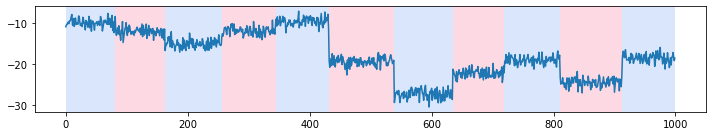

In [455]:
fig, ax_array = rpt.display(signal, bkps)

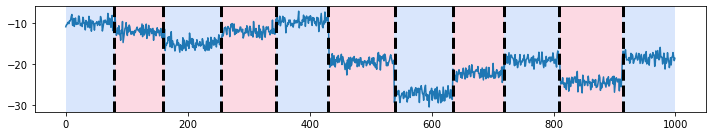

In [456]:
algo = rpt.Pelt(model='l2', min_size=3).fit(signal)
my_bkps = algo.predict(pen=100)
rpt.display(signal, bkps, my_bkps)
plt.show()

One sees that without outliers, changepoint detection (without a known number of changepoints, in this case perfomed by (https://centre-borelli.github.io/ruptures-docs/user-guide/detection/pelt/)[Pelt]), works perfectly.

In [461]:
#utils
def add_outliers(n_outliers,signal):
    
    """return signal with n_outliers outliers added. Outliers are added randomly and 
       have magnitude 1-5 the mean of the signal
    
    Arguments :
        n_outliers : int
        signal : numpy.array
    """
    
    sig_length = signal.size
    outliers = np.random.choice(np.arange(1,sig_length),n_outliers,replace=False)
    test = np.zeros(sig_length)
    test[outliers] = 1
    magnitude_max = 10 #controls the maximum magnitude of outliers
    test = test*np.random.choice([-1,1], sig_length)*np.random.choice(np.arange(1,magnitude_max),sig_length)*(signal.mean()+20)
    test = test.reshape(sig_length,1)
    signal = signal + test
    return signal, outliers

In [462]:
noisy_signal, _= add_outliers(100,signal)

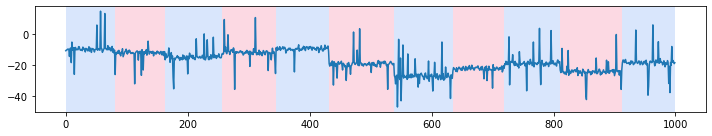

In [463]:
fig, ax_array = rpt.display(noisy_signal, bkps)

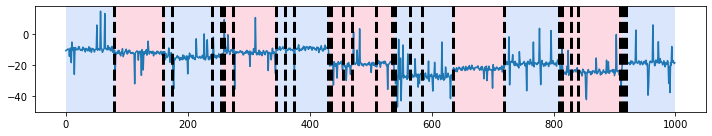

In [466]:
algo = rpt.Pelt(model='l2', min_size=3).fit(signal)
my_bkps = algo.predict(pen=4)
rpt.display(noisy_signal, bkps, my_bkps)
plt.show()

As one can see, classical changepoint methods fail when the signal has many outliers.

## R-FPOP :  an algorithm robust to outliers

This section implements the algorithm R-FPOP through the 4 sub-algorithms presented in the original article.

In [467]:
def biweighloss(yt, K):
    first_part = ((-np.inf, yt-K), np.array([0,0,K*K]))
    second_part = ((yt-K, yt+K), np.array([1, -2*yt, yt**2]))
    third_part = ((yt+K, np.inf), np.array([0,0,K*K]))
    return [first_part, second_part, third_part]

In [468]:
def alg2(Qt_star, tau_star, gamma_t_yt):
    Qt, tau = [], []
    Nt_star = len(Qt_star)
    l = len(gamma_t_yt)
    Nt = 0
    i = 0
    j = 0
    while i < Nt_star and j < l:
        if Qt_star[i][0][1] < gamma_t_yt[j][0][0] :
            i+=1
        elif gamma_t_yt[j][0][1] < Qt_star[i][0][0] :
            j+=1
        else :
            Nt += 1
            # intersection of intervals 
            a = max([Qt_star[i][0][0], gamma_t_yt[j][0][0]])
            b = min([Qt_star[i][0][1], gamma_t_yt[j][0][1]])
            params = Qt_star[i][1] + gamma_t_yt[j][1]
            Qt.append( ((a,b), params) )
            tau.append( tau_star[i] )
            if b == Qt_star[i][0][1]:
                # new interval for Qt*
                i += 1
            if b == gamma_t_yt[j][0][1]:
                # new interval for gamma_yt
                j += 1
    return Qt.copy(), tau.copy()

In [469]:
def alg3(Qt, tau):
    Qt_min = np.inf
    tau_min = 0
    for i, ((a, b), params) in enumerate(Qt):
        quad = lambda x : np.dot(x**np.array([2,1,0]),params)
        if params[0] > 0:
            # the function is quadratic and convex
            global_minimizer = -params[1]/2/params[0]
            if a < global_minimizer < b :
                # the global minimizer is in [a,b]
                m = quad(global_minimizer)
            else:
                # the function is monotone on [a,b]
                m = min(quad(a),quad(b))
        else:
            # the function is concave
            m = min(quad(a),quad(b))
        if m < Qt_min:
            Qt_min = m
            tau_min = tau[i]
    return Qt_min, tau_min

In [470]:
def alg4(t, Qt, tau, C):
    Qt_star, tau_star = [], []
    for i, ((x0, x1), params) in enumerate(Qt):
        quad = lambda x : np.dot(x**np.array([2,1,0]),params) - C
        a, b, c = params

        # compute the root(s) of Qt - C
        if a != 0:
            # quadratic case
            delta = b*b - 4*a*(c - C)
            if delta > 0:
                roots = [(-b-np.sqrt(delta))/(2*a), (-b+np.sqrt(delta))/(2*a)]
            elif delta == 0:
                roots = [-b/(2*a)]
            else:
                roots = []
        elif b != 0:
            # linear case
            roots = [(C - c) / b]
        else :
            # constant case
            roots = []
        
        # create the vector R as in the paper
        R = [x0]
        for root in roots: R.append(root) if (x0 < root < x1) else None
        R.append(x1)

        for j in range(len(R) - 1):
            if quad( np.mean(R[j:j+2]) )>=0 :
                # positif over the interval [R_j, R_j+1]
                Qt_star.append( ((R[j], R[j+1]), np.array([0, 0, C])) )
                tau_star.append(t)
            else:
                # negatif over the interval [R_j, R_j+1]
                Qt_star.append( ((R[j], R[j+1]), params) )
                tau_star.append(tau[i])
        
    return Qt_star, tau_star

In [471]:
def R_FPOP(y, gamma,K, beta):
    Qt_star = [((min(y), max(y)), np.zeros(3))]
    tau_star = [0,100]
    change_points = []
    for t in tqdm.tqdm(range(len(y))):
        Qt, tau = alg2(Qt_star, tau_star, gamma(y[t],K))
        Qt_min, tau_min = alg3(Qt, tau)
        change_points.append([Qt_min[0], tau_min])
        Qt_star, tau_star = alg4(t, Qt, tau, Qt_min + beta)
    change_points = sorted(np.unique(np.array(change_points)[:,1])) + [len(y)]
    return change_points

# A few simple tests on synthetic data

## Tests with Cauchy noise

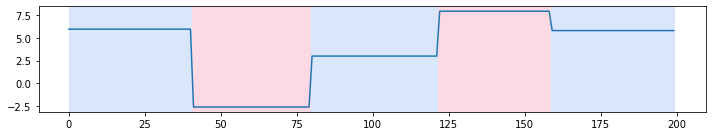

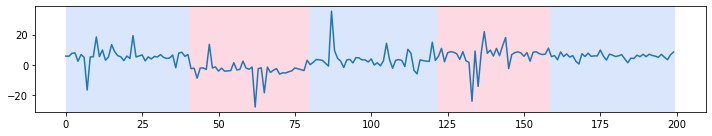

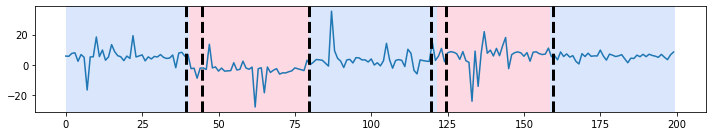

In [472]:
# parameters
n_samples, n_dims, sigma = 200, 1, 2
n_bkps = 4  # number of breakpoints
np.random.seed(12)

# base signal
signal, bkps = rpt.pw_constant(n_samples, n_dims, n_bkps, noise_std=0,seed=3)
rpt.display(signal, bkps)
#plt.title('Original signal')
plt.savefig('originalsig.pdf')

# base signal + heavy-tailed noise
cauchy_signal = signal+ np.random.standard_cauchy((n_samples,n_dims))
rpt.display(cauchy_signal, bkps)
#plt.title('Original signal with heavy tail noise')
plt.savefig('signalwcnoise.pdf')

# changepoint detection on base signal
algo = rpt.Pelt(model="l2").fit(signal)
result = algo.predict(pen=7)
rpt.display(cauchy_signal, bkps, result)
#plt.title('Changepoint detection with MSE loss')
plt.savefig('changepointmsecnoise.pdf')

  0%|          | 0/200 [00:00<?, ?it/s]

/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[0.0, 40.0, 78.0, 121.0, 200]


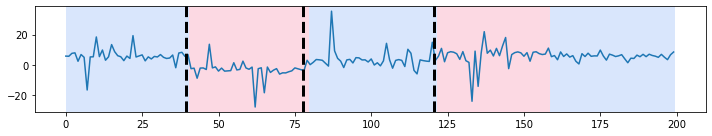

In [473]:
# changepoint detection with R-FPOP
K= cauchy_signal.std()
change_points = R_FPOP(cauchy_signal, biweighloss,K,80)
print(change_points)
rpt.display(cauchy_signal, bkps, change_points)
plt.savefig('rfpopht.pdf')

## Hawkes noise

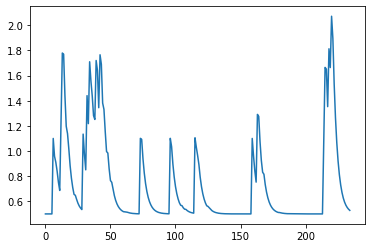

In [474]:
# Simulation of a hawkes process
n_nodes = 2  # dimension of the Hawkes process
adjacency = 0.2 * np.ones((n_nodes, n_nodes))
adjacency[0, 1] = 0
decays = 3 * np.ones((n_nodes, n_nodes))
baseline = 0.5 * np.ones(n_nodes)
hawkes = SimuHawkesExpKernels(adjacency=adjacency, decays=decays,
                              baseline=baseline, verbose=False, seed=2398)

run_time = 20
hawkes.end_time = run_time
dt = 0.1
hawkes.track_intensity(dt)
hawkes.simulate()
noise = np.array(hawkes.tracked_intensity)[0,:]
plt.plot(noise)

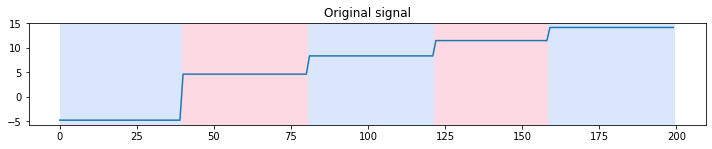

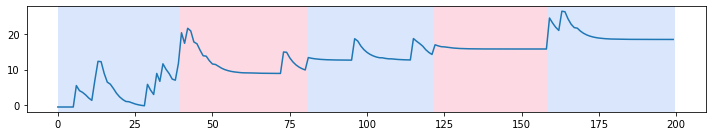

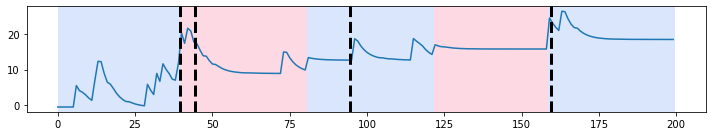

In [475]:
# parameters
n_samples, n_dims, sigma = 200, 1, 10
n_bkps = 4  # number of breakpoints
np.random.seed(15)

# base signal
signal, bkps = rpt.pw_constant(n_samples, n_dims, n_bkps, noise_std=0,seed=1)
rpt.display(signal, bkps)
plt.title('Original signal')

# base signal + heavy-tailed noise
hawkes_sig =signal+ sigma * noise[:n_samples].reshape((n_samples,1)) - np.mean(noise)
rpt.display(hawkes_sig, bkps)
plt.savefig('signalwoutliers.pdf')

# changepoint detection on base signal
algo = rpt.Dynp(model="l2").fit(hawkes_sig)
result = algo.predict(n_bkps=4)
rpt.display(hawkes_sig, bkps, result)
plt.savefig('msehawkes.pdf')

  0%|          | 0/200 [00:00<?, ?it/s]

/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[0.0, 31.0, 72.0, 80.0, 95.0, 158.0, 200]


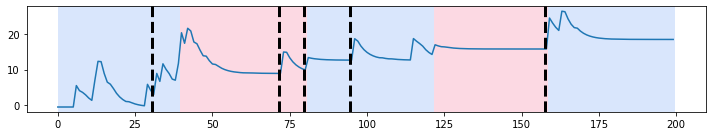

In [476]:
# changepoint detection with R-FPOP
K= 1*hawkes_sig.std()
change_points = R_FPOP(hawkes_sig, biweighloss,K,250)
print(change_points)
rpt.display(hawkes_sig, bkps, change_points)
plt.savefig('hawkesout.pdf')

## Tests with different types of outliers

### Tests with many outliers

Text(0.5, 1.0, 'Changepoint detection with MSE loss')

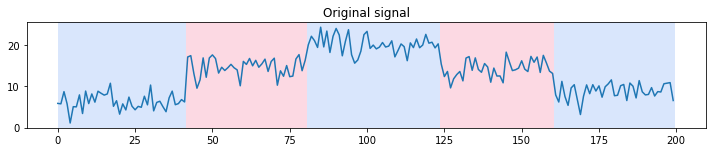

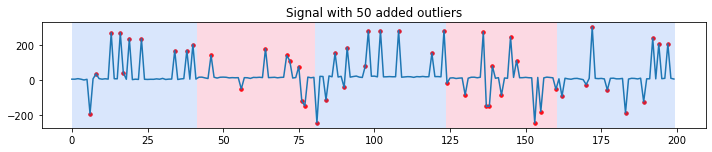

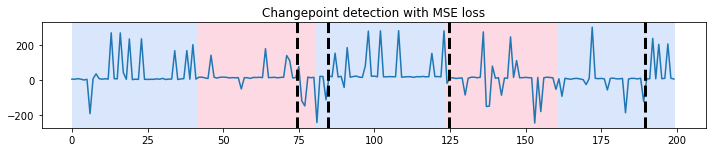

In [483]:
# parameters
n_samples, n_dims, sigma = 200, 1, 2
n_bkps = 4  # number of breakpoints
np.random.seed(0)


# base signal
signal, bkps = rpt.pw_constant(n_samples, n_dims, n_bkps, noise_std=sigma, seed=0)
rpt.display(signal, bkps)
plt.title('Original signal')

# signal with outliers
new_sig,outliers = add_outliers(50,signal)
rpt.display(new_sig, bkps)
outliers_points = new_sig[outliers]
plt.scatter(x=outliers,y=outliers_points,c='red',s=12)
plt.title("Signal with 50 added outliers")

# changepoint detection on base signal
algo = rpt.Dynp(model="l2").fit(new_sig)
result = algo.predict(n_bkps=4)
rpt.display(new_sig, bkps, result)
plt.title('Changepoint detection with MSE loss')

### Grouped outliers

In [479]:
def add_grouped_outliers(n_group, group_length, signal):
    """return the signal in input with n_group groups of outliers.
    The length of each group is group_length
    Args :
        n_groupe : int
        group_length : int
        signal : numpy.array
    """
    sig_length = signal.size
    index = np.arange(sig_length-group_length, dtype=int)
    outliers = []
    for i in range(n_group) :
        outlier = np.random.choice(index,1)[0]
        outliers.append(list(range(outlier,outlier+group_length)))
        index = index[np.abs(index-outlier)>group_length]

    test = np.zeros(sig_length)
    for i in range(len(outliers)) :
        outlier = outliers[i][0]
        test[outlier:outlier+group_length] = np.random.choice([1,-1])*np.random.choice(np.arange(1,5))*signal.mean()

    test = test.reshape(sig_length,1)
    signal = signal + test
    outliers = np.array(outliers).flatten()
    return signal, outliers

Text(0.5, 1.0, 'Changepoint detection with MSE loss in the presence of outliers')

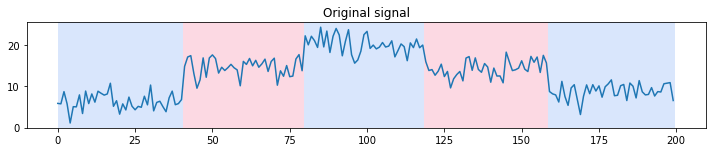

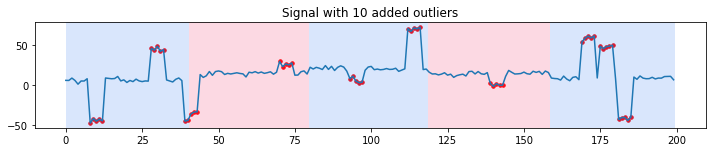

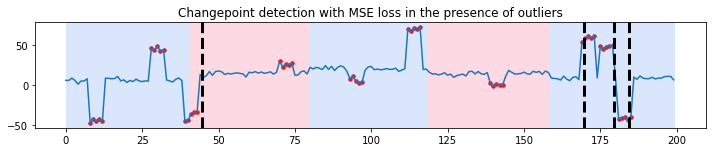

In [480]:
# parameters
n_samples, n_dims, sigma = 200, 1, 2
n_bkps = 4  # number of breakpoints
np.random.seed(16)


# base signal
signal, bkps = rpt.pw_constant(n_samples, n_dims, n_bkps, noise_std=sigma, seed=0)
rpt.display(signal, bkps)
plt.title('Original signal')

# signal with grouped outliers
new_sig,outliers = add_grouped_outliers(10,5,signal)
rpt.display(new_sig, bkps)
outliers_points = new_sig[outliers]
plt.scatter(x=outliers,y=outliers_points,c='red',s=12)
plt.title("Signal with 10 added outliers")

# changepoint detection on modified signal
algo = rpt.Dynp(model="l2").fit(new_sig)
result = algo.predict(n_bkps=4)
rpt.display(new_sig, bkps, result)
plt.scatter(x=outliers,y=outliers_points,c='red',s=12)
plt.title("Changepoint detection with MSE loss in the presence of outliers")

  0%|          | 0/200 [00:00<?, ?it/s]

/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[0.0, 43.0, 79.0, 118.0, 158.0, 200]


Text(0.5, 1.0, 'Changepoint detection with R-FPOP')

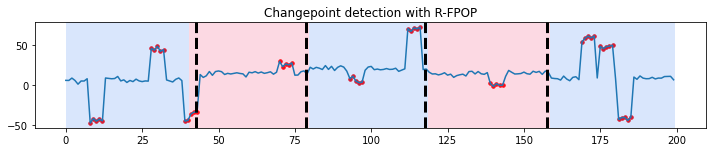

In [481]:
# changepoint detection with R-FPOP
K= .2*new_sig.std()
change_points = R_FPOP(new_sig, biweighloss,K,100)
print(change_points)
rpt.display(new_sig, bkps, change_points)
outliers_points = new_sig[outliers]
plt.scatter(x=outliers,y=outliers_points,c='red',s=12)
plt.title('Changepoint detection with R-FPOP')

# Some other tests on real data

We first test the method on the well-log dataset.

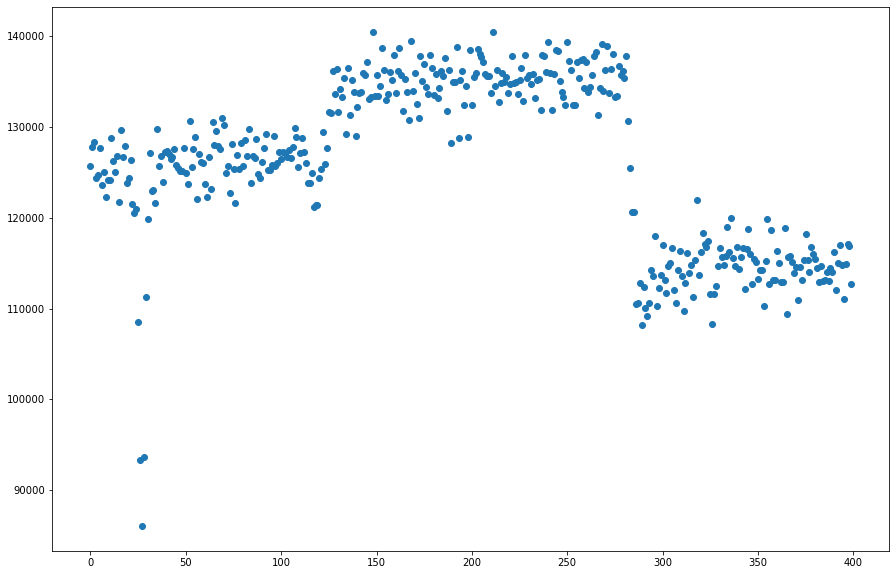

In [193]:
import pandas as pd

df = pd.read_csv('data/well_log/well_log.txt')
df.head()

df = df.rename(columns={"1.3353060e+05": "value"})

wl_signal = np.array(df.values)[1400:1800]

f,ax=plt.subplots(figsize=(15,10))

plt.scatter(np.arange(len(wl_signal)),wl_signal);

In [219]:
K= 2*wl_signal.std()
change_points = R_FPOP((wl_signal-wl_signal.mean())/wl_signal.std(), biweighloss,K,30)

  0%|          | 0/400 [00:00<?, ?it/s]/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
100%|██████████| 400/400 [00:11<00:00, 35.69it/s] 


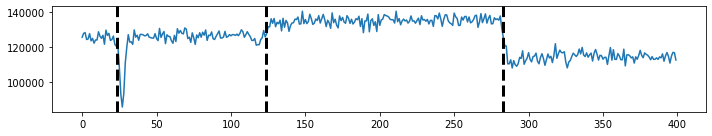

In [200]:
rpt.display(wl_signal,[], change_points)
plt.savefig('well_log.pdf')

We now test our data on another dataset recording CO2 emissions per personn (in tonnes) in Canada, recorded from 1800 until 2014.

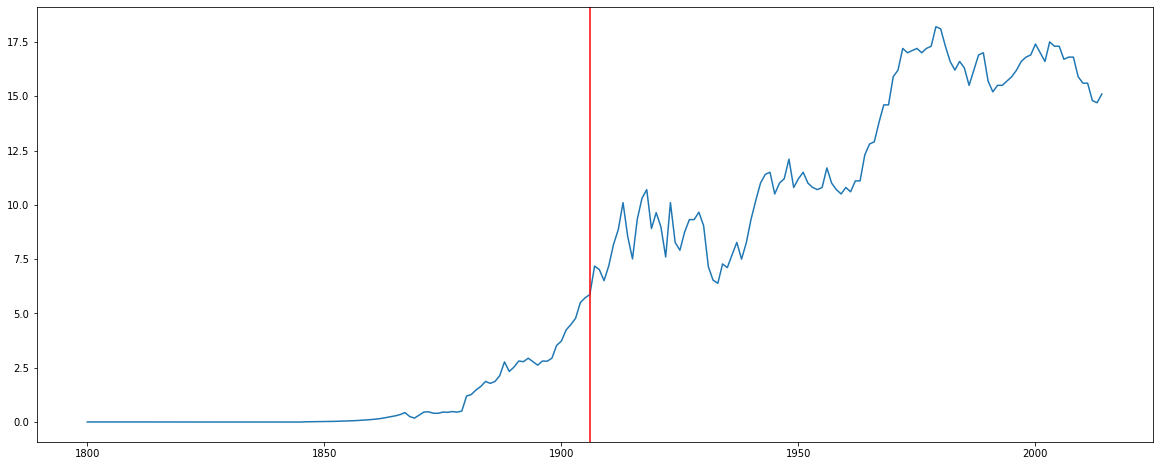

In [448]:
df = pd.read_csv('data/co2/co2.csv')

df.head()

years = np.array(df.country)
co2_signal = np.array(df.Canada).reshape(len(co2_signal),-1)

f,ax=plt.subplots(figsize=(20,8))

plt.plot(years,co2_signal)
plt.axvline(x=1906,c='red');
plt.savefig('canada.pdf')

In [442]:
K= 4
change_points = R_FPOP((co2_signal-co2_signal.mean())/co2_signal.std(), biweighloss,K,130)

  0%|          | 0/215 [00:00<?, ?it/s]/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
100%|██████████| 215/215 [00:01<00:00, 151.76it/s]


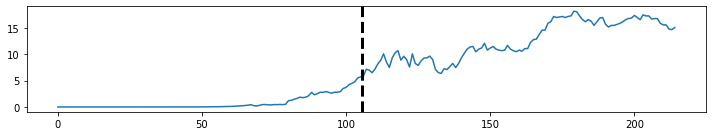

In [443]:
rpt.display(co2_signal,[], change_points)
#plt.savefig('well_log.pdf')
plt.savefig('co2canada.pdf')

Finally, we test the algorithm on COVID-19 number of deaths.

In [353]:
df = pd.read_csv('data/covid/covid.csv')

france_death = np.array(df[df.location == 'France']['new_deaths_smoothed'])
germany_death = np.array(df[df.location == 'Germany']['new_deaths_smoothed'])
usa_death = np.array(df[df.location == 'United States']['new_deaths_smoothed'])

france_death = france_death.reshape(len(france_death),-1)[37:]
germany_death = germany_death.reshape(len(germany_death),-1)[34:]
usa_death = usa_death.reshape(len(usa_death),-1)[39:]

from datetime import date, timedelta

sdate = date(2020, 3, 1)  
edate = date(2021, 3, 31)   

delta = edate - sdate       

dates =[]

for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    dates.append(day)

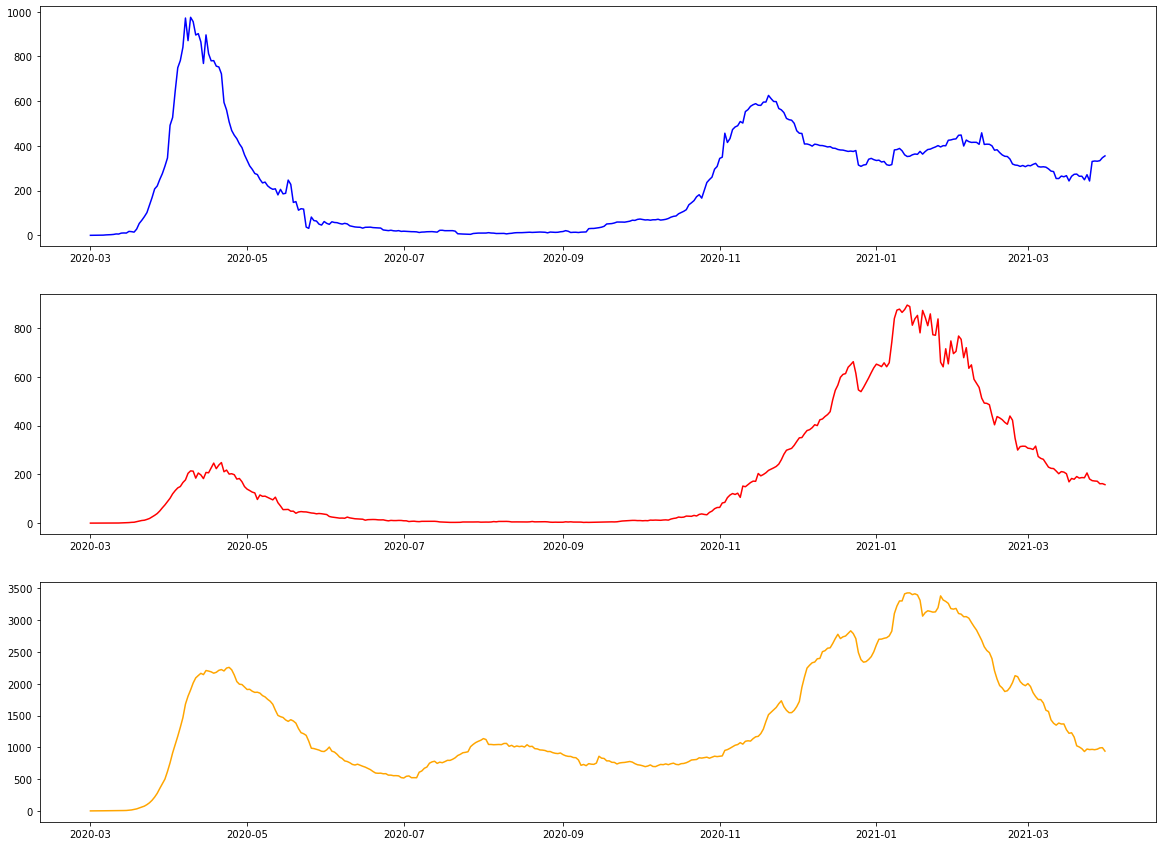

In [421]:
f,ax = plt.subplots(3,1,figsize=(20,15))

ax[0].plot(dates,france_death,c='blue')
ax[1].plot(dates,germany_death,c='red')
ax[2].plot(dates,usa_death,c='orange');
plt.savefig('covid.pdf')

In [417]:
K_f= 2*france_death.std()
change_points_fr = R_FPOP((france_death-france_death.mean())/france_death.std(), biweighloss,K,105)

  0%|          | 0/396 [00:00<?, ?it/s]/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
100%|██████████| 396/396 [00:06<00:00, 63.88it/s] 


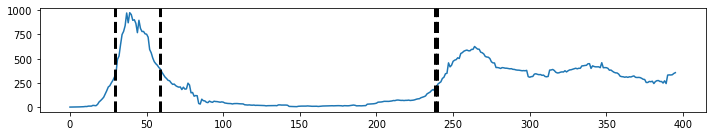

In [418]:
rpt.display(france_death,[], change_points_fr)
plt.savefig('covidfr.pdf')

In [408]:
K_g= 3*germany_death.std()
change_points_ger = R_FPOP((germany_death-germany_death.mean())/germany_death.std(), biweighloss,K,105)

  0%|          | 0/396 [00:00<?, ?it/s]/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
100%|██████████| 396/396 [00:05<00:00, 66.69it/s] 


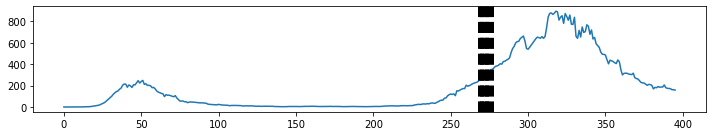

In [419]:
rpt.display(germany_death,[], change_points_ger)
plt.savefig('covidger.pdf')

In [414]:
K_us= 3*usa_death.std()
change_points_us = R_FPOP((usa_death-usa_death.mean())/usa_death.std(), biweighloss,K,50)

  0%|          | 0/396 [00:00<?, ?it/s]/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
100%|██████████| 396/396 [00:09<00:00, 42.67it/s] 


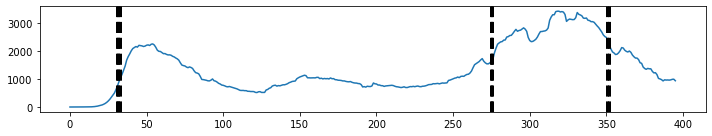

In [420]:
rpt.display(usa_death,[], change_points_us)
plt.savefig('covidusa.pdf')

[0.0, 269.0, 270.0, 271.0, 272.0, 273.0, 274.0, 275.0, 277.0, 396]


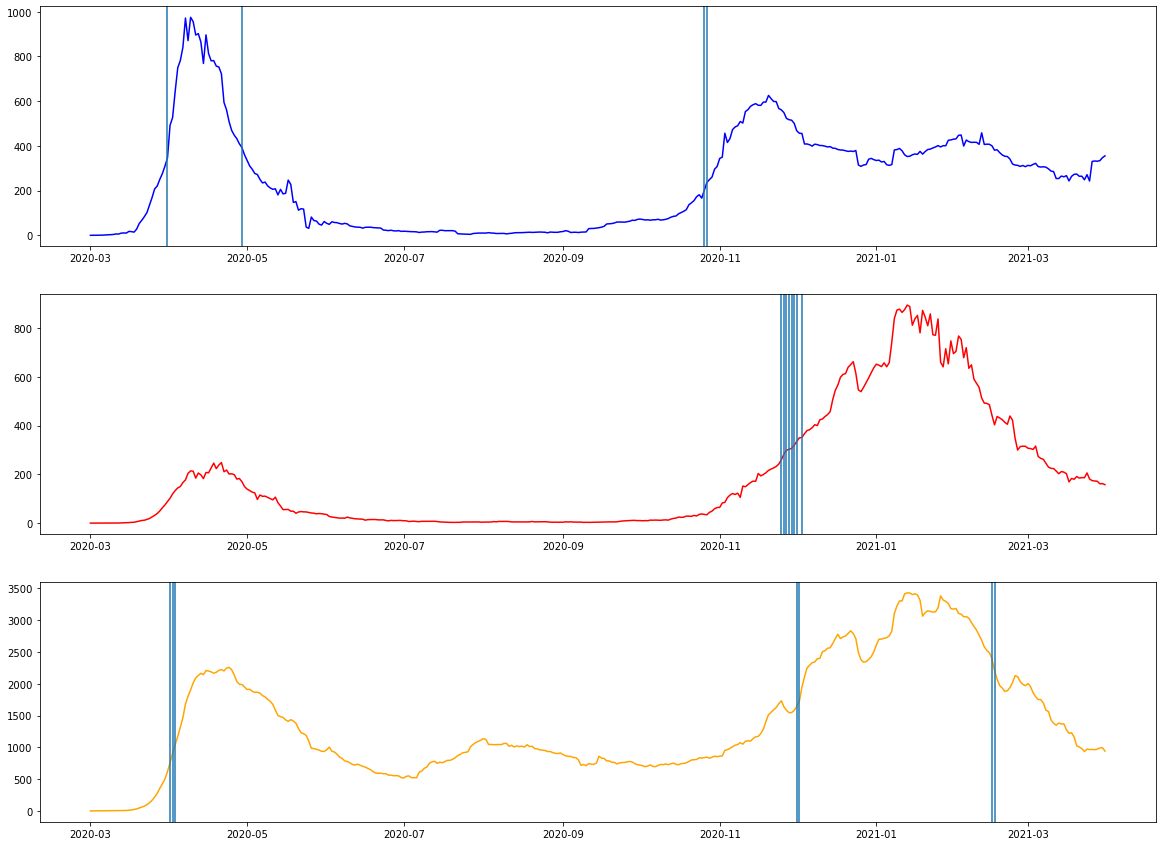

In [440]:
f,ax = plt.subplots(3,1,figsize=(20,15))
print(change_points_ger)
ax[0].plot(dates,france_death,c='blue')
for points in change_points_fr[1:-1]:
    ax[0].axvline(x=dates[int(points)])
ax[1].plot(dates,germany_death,c='red')
for points in change_points_ger[1:-1]:
    ax[1].axvline(x=dates[int(points)])
ax[2].plot(dates,usa_death,c='orange');
for points in change_points_us[1:-1]:
    ax[2].axvline(x=dates[int(points)])
plt.savefig('covid.pdf')
